# Inference: So Sánh Phương Pháp MoE + Plugin vs Paper Method (CE + Plugin)

Notebook này thực hiện inference và so sánh phương pháp của bạn (3 Experts + Gating + Plugin) với paper method (CE + Plugin) trên một ảnh tail class.

## Nội dung:
1. Setup và imports
2. Load models và data
3. Chạy Paper Method (CE + Plugin)
4. Chạy Our Method (MoE + Plugin)
5. So sánh từng metric riêng biệt
6. Visualization

## 0. Dataset Distribution Overview


📊 CIFAR-100 Long-Tail Dataset Distribution

Total classes: 100
Head classes (> 20 samples): 69
Tail classes (≤ 20 samples): 31

Head class stats:
  Min: 21, Max: 500, Mean: 152.5

Tail class stats:
  Min: 5, Max: 20, Mean: 10.5

Imbalance factor (max/min): 100.0x


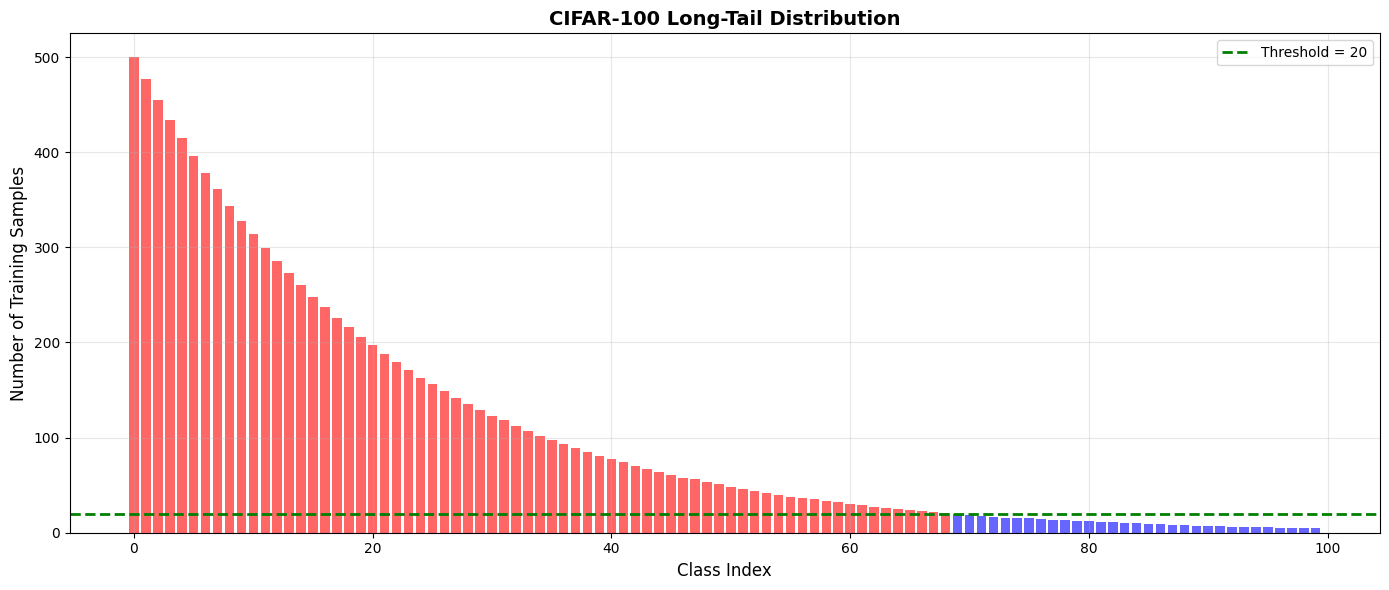

In [1]:
# CIFAR-100 Long-Tail Dataset Distribution
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATASET = 'cifar100_lt_if100'
splits_dir = Path(f"./data/{DATASET}_splits_fixed")
counts_path = splits_dir / "train_class_counts.json"

with open(counts_path, 'r') as f:
    counts = json.load(f)

if isinstance(counts, dict):
    class_counts = np.array([counts[str(i)] for i in range(100)])
else:
    class_counts = np.array(counts)

TAIL_THRESHOLD = 20
head_mask = class_counts > TAIL_THRESHOLD
tail_mask = class_counts <= TAIL_THRESHOLD

num_head = head_mask.sum()
num_tail = tail_mask.sum()

print("=" * 70)
print("📊 CIFAR-100 Long-Tail Dataset Distribution")
print("=" * 70)
print(f"\nTotal classes: {len(class_counts)}")
print(f"Head classes (> {TAIL_THRESHOLD} samples): {num_head}")
print(f"Tail classes (≤ {TAIL_THRESHOLD} samples): {num_tail}")
print(f"\nHead class stats:")
print(f"  Min: {class_counts[head_mask].min()}, Max: {class_counts[head_mask].max()}, Mean: {class_counts[head_mask].mean():.1f}")
print(f"\nTail class stats:")
print(f"  Min: {class_counts[tail_mask].min()}, Max: {class_counts[tail_mask].max()}, Mean: {class_counts[tail_mask].mean():.1f}")
print(f"\nImbalance factor (max/min): {class_counts.max() / class_counts.min():.1f}x")

# Visualize distribution
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Distribution plot
ax.bar(range(len(class_counts)), class_counts, color=['red' if c > TAIL_THRESHOLD else 'blue' for c in class_counts], alpha=0.6)
ax.axhline(y=TAIL_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Threshold = {TAIL_THRESHOLD}')
ax.set_xlabel('Class Index', fontsize=12)
ax.set_ylabel('Number of Training Samples', fontsize=12)
ax.set_title('CIFAR-100 Long-Tail Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 1. Setup và Imports

In [2]:
# Setup imports
import sys
from pathlib import Path
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

from src.infer import (
    load_class_to_group,
    load_test_sample_with_image,
    load_image_from_infer_samples,
    load_all_experts,
    load_gating_network,
    load_plugin_params,
    paper_method_pipeline,
    our_method_pipeline,
    plot_ce_only_full_class_distribution,
    plot_full_class_distribution,
    compute_rejection_thresholds_from_test_set,
    BalancedLtRPlugin,
    DATASET, DEVICE, OUTPUT_DIR, EXPERT_DISPLAY_NAMES, NUM_CLASSES, EXPERT_NAMES
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Imports successful!")


✅ Imports successful!


## 2. Configuration

In [3]:
# Configuration: Interactive image selection and rejection rate
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

print(f"📁 Dataset: {DATASET}")
print(f"📁 Device: {DEVICE}")

# Initialize variables (will be set by widget)
selected_image_path = None
selected_class_idx = None
selected_group = None
use_cifar100_dataset = False
selected_mode = "worst"  # "balanced" or "worst"
selected_rejection_rate = 0.3  # Target rejection rate

def scan_infer_samples():
    """Scan infer_samples folder and return available images grouped by mode and head/tail."""
    infer_samples_dir = Path("./infer_samples")
    images = {
        'balanced': {'head': [], 'tail': []},
        'worst': {'head': [], 'tail': []},
        'Others': []
    }
    
    for mode in ['balanced', 'worst']:
        mode_dir = infer_samples_dir / mode
        if mode_dir.exists():
            for group in ['head', 'tail']:
                group_dir = mode_dir / group
                if group_dir.exists():
                    for img_file in sorted(group_dir.glob("*.png")):
                        images[mode][group].append(str(img_file))
    
    # Scan Others folder (unchanged)
    others_dir = infer_samples_dir / "Others"
    if others_dir.exists():
        for ext in ["*.png", "*.jpg", "*.jpeg"]:
            for img_file in sorted(others_dir.glob(ext)):
                images['Others'].append(str(img_file))
    
    return images

def create_image_selector():
    """Create interactive widget to select image."""
    images = scan_infer_samples()
    
    # Create source selector
    source_selector = widgets.RadioButtons(
        options=['infer_samples', 'CIFAR-100 dataset'],
        value='infer_samples',
        description='Image Source:',
        style={'description_width': 'initial'}
    )
    
    # Create category selector for infer_samples (mode + group)
    category_selector = widgets.Dropdown(
        options=['balanced - head', 'balanced - tail', 'worst - head', 'worst - tail', 'Others'],
        value='balanced - tail',
        description='Category:',
        style={'description_width': 'initial'}
    )
    
    # Create image selector
    def get_image_options(category):
        if category.startswith('balanced'):
            group = 'head' if 'head' in category else 'tail'
            return images['balanced'][group]
        elif category.startswith('worst'):
            group = 'head' if 'head' in category else 'tail'
            return images['worst'][group]
        else:
            return images['Others']
    
    image_options = get_image_options(category_selector.value)
    image_selector = widgets.Dropdown(
        options=image_options if image_options else ['No images found'],
        description='Select Image:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='600px')
    )
    
    # CIFAR-100 dataset options
    cifar100_class_selector = widgets.IntText(
        value=70,
        description='Class Index (0-99):',
        style={'description_width': 'initial'},
        disabled=True
    )
    
    cifar100_random_checkbox = widgets.Checkbox(
        value=False,
        description='Random tail class',
        style={'description_width': 'initial'},
        disabled=True
    )
    
    # Output area
    output = widgets.Output()
    
    def update_category(change):
        """Update image options when category changes."""
        new_options = get_image_options(change['new'])
        if new_options:
            image_selector.options = new_options
            image_selector.value = new_options[0] if new_options else None
        else:
            image_selector.options = ['No images found']
    
    def update_source(change):
        """Enable/disable widgets based on source."""
        if change['new'] == 'infer_samples':
            category_selector.disabled = False
            image_selector.disabled = False
            cifar100_class_selector.disabled = True
            cifar100_random_checkbox.disabled = True
        else:
            category_selector.disabled = True
            image_selector.disabled = True
            cifar100_class_selector.disabled = False
            cifar100_random_checkbox.disabled = False
    
    def on_select_button_click(b):
        """Handle select button click."""
        global selected_image_path, selected_class_idx, selected_group, use_cifar100_dataset
        
        with output:
            clear_output(wait=True)
            if source_selector.value == 'infer_samples':
                if image_selector.value and image_selector.value != 'No images found':
                    selected_image_path = Path(image_selector.value)
                    selected_class_idx = None
                    selected_group = None
                    use_cifar100_dataset = False
                    
                    # Try to parse class info from filename and folder structure
                    # Expect structure: infer_samples/<mode>/<head|tail>/head_{class}_{name}_idxXXX.png
                    if selected_image_path.parent.name in ['head', 'tail']:
                        selected_group = selected_image_path.parent.name
                    filename = selected_image_path.stem
                    parts = filename.split('_')
                    if len(parts) >= 3 and parts[0] in ['head', 'tail']:
                        if selected_group is None:
                            selected_group = parts[0]
                        try:
                            selected_class_idx = int(parts[1])
                        except:
                            pass
                    
                    print(f"✅ Selected: {selected_image_path.name}")
                    if selected_class_idx is not None:
                        print(f"   Class: {selected_class_idx}, Group: {selected_group}")
                else:
                    print("⚠️  Please select an image")
            else:
                selected_image_path = None
                selected_group = None
                use_cifar100_dataset = True
                if cifar100_random_checkbox.value:
                    selected_class_idx = None
                    print("✅ Selected: Random tail class from CIFAR-100")
                else:
                    selected_class_idx = cifar100_class_selector.value
                    print(f"✅ Selected: Class {selected_class_idx} from CIFAR-100")
    
    category_selector.observe(update_category, names='value')
    source_selector.observe(update_source, names='value')
    
    select_button = widgets.Button(
        description='Select Image',
        button_style='success',
        icon='check'
    )
    select_button.on_click(on_select_button_click)
    
    # Layout
    vbox = widgets.VBox([
        source_selector,
        widgets.HBox([category_selector, image_selector]),
        widgets.HBox([cifar100_class_selector, cifar100_random_checkbox]),
        select_button,
        output
    ])
    
    return vbox

# Create rejection rate and mode selector
def create_config_selector():
    """Create widget to select mode and rejection rate."""
    global selected_mode, selected_rejection_rate
    
    # Mode selector
    mode_selector = widgets.RadioButtons(
        options=['balanced', 'worst'],
        value='worst',
        description='Mode:',
        style={'description_width': 'initial'}
    )
    
    # Rejection rate selector (available rates differ by mode)
    # Balanced: [0.0, 0.1, 0.2, 0.3, 0.4, 0.499, 0.599, 0.699, 0.799]
    # Worst: [0.0, 0.073, 0.156, 0.235, 0.325, 0.423, 0.52, 0.607, 0.726, 0.859]
    balanced_rrs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    worst_rrs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    
    rr_selector = widgets.Dropdown(
        options=worst_rrs,
        value=0.3,
        description='Rejection Rate:',
        style={'description_width': 'initial'}
    )
    
    def update_rr_options(change):
        """Update rejection rate options when mode changes."""
        if change['new'] == 'balanced':
            # Round available rates to match selector
            rr_selector.options = balanced_rrs
        else:
            rr_selector.options = worst_rrs
        # Keep current value if available, otherwise use 0.3
        if rr_selector.value not in rr_selector.options:
            rr_selector.value = 0.3
    
    mode_selector.observe(update_rr_options, names='value')
    
    output_config = widgets.Output()
    
    def on_config_button_click(b):
        """Handle config button click."""
        global selected_mode, selected_rejection_rate
        selected_mode = mode_selector.value
        selected_rejection_rate = rr_selector.value
        
        with output_config:
            clear_output(wait=True)
            print(f"✅ Configuration updated:")
            print(f"   Mode: {selected_mode}")
            print(f"   Rejection Rate: {selected_rejection_rate}")
    
    config_button = widgets.Button(
        description='Set Configuration',
        button_style='info',
        icon='cog'
    )
    config_button.on_click(on_config_button_click)
    
    vbox_config = widgets.VBox([
        widgets.HBox([mode_selector, rr_selector]),
        config_button,
        output_config
    ])
    
    return vbox_config

# Display widgets
print("\n" + "="*70)
print("⚙️  CONFIGURATION")
print("="*70)
print("1. Select Plugin Mode and Rejection Rate:")
config_selector_widget = create_config_selector()
display(config_selector_widget)

print("\n2. Select Image:")
image_selector_widget = create_image_selector()
display(image_selector_widget)

📁 Dataset: cifar100_lt_if100
📁 Device: cpu

⚙️  CONFIGURATION
1. Select Plugin Mode and Rejection Rate:



2. Select Image:


## 3. Load Data


📷 Loaded image from: infer_samples/worst/tail/tail_73_shark_idx2208.png
   Class: 73 (shark_idx2208)
   Image shape: (32, 32, 3)

✅ Tail class - Group: 1


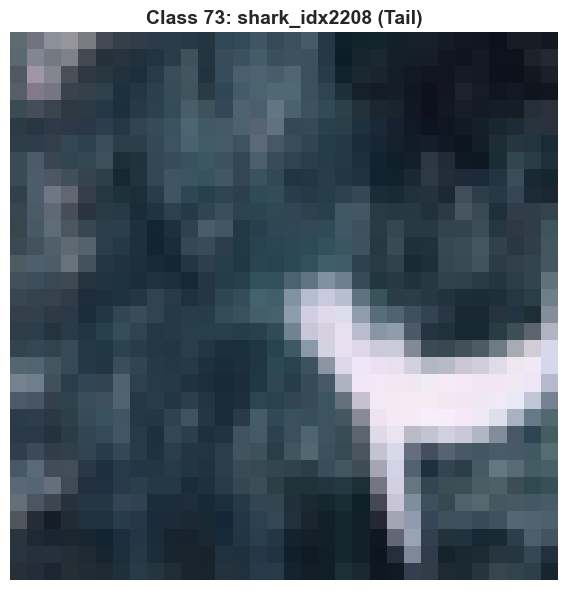

In [5]:
# Load class-to-group mapping
class_to_group = load_class_to_group()

# Load CIFAR-100 class names (for reference)
dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
class_names = dataset.classes

# Load image based on selection from widget
# Check if image has been selected
if not use_cifar100_dataset and selected_image_path is None and (selected_class_idx is None or selected_group is None):
    raise ValueError(
        "⚠️  Please select an image first!\n"
        "   1. Go to the 'Configuration' cell (section 2)\n"
        "   2. Use the image selector widget to choose an image\n"
        "   3. Click the 'Select Image' button\n"
        "   4. Then run this cell again"
    )

if use_cifar100_dataset:
    # Load from CIFAR-100 dataset
    image_tensor, true_label, image_array, class_name = load_test_sample_with_image(class_idx=selected_class_idx)
else:
    # Load from infer_samples folder
    # Use image_path if available, otherwise use class_idx and group
    if selected_image_path is not None and selected_image_path.exists():
        image_tensor, true_label, image_array, class_name = load_image_from_infer_samples(
            image_path=selected_image_path,
            class_idx=None,
            group=None
        )
    elif selected_class_idx is not None and selected_group is not None:
        image_tensor, true_label, image_array, class_name = load_image_from_infer_samples(
            image_path=None,
            class_idx=selected_class_idx,
            group=selected_group
        )
    else:
        raise ValueError(
            f"Cannot load image: image_path={selected_image_path}, "
            f"class_idx={selected_class_idx}, group={selected_group}\n"
            "Please go back to Configuration cell and select an image."
        )

# Check if it's tail (only if true_label is valid CIFAR-100 class)
if true_label >= 0 and true_label < len(class_to_group):
    is_tail = class_to_group[true_label].item() == 1
    print(f"\n{'✅ Tail class' if is_tail else '⚠️  Not tail class'} - Group: {class_to_group[true_label].item()}")
else:
    print(f"\n⚠️  Note: Class label {true_label} may not be from CIFAR-100 dataset")
    is_tail = None

# TO DO: Plot image
plt.figure(figsize=(6, 6))
plt.imshow(image_array)
plt.title(f"Class {true_label}: {class_name} ({'Tail' if is_tail else 'Head'})", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()



## 4. Load Models

In [6]:
experts = load_all_experts()
ce_expert = experts[0] 
gating = load_gating_network()

# Load plugin parameters for both methods using selected mode and rejection_rate
print(f"\n📋 Loading plugin parameters:")
print(f"   Mode: {selected_mode}")
print(f"   Rejection Rate: {selected_rejection_rate}")

ce_plugin_alpha, ce_plugin_mu, ce_plugin_cost = load_plugin_params(
    method="ce_only", 
    mode=selected_mode,
    rejection_rate=selected_rejection_rate
)
moe_plugin_alpha, moe_plugin_mu, moe_plugin_cost = load_plugin_params(
    method="moe", 
    mode=selected_mode,
    rejection_rate=selected_rejection_rate
)

print("\n✅ All models and parameters loaded successfully!")


✅ Loaded ce_baseline expert
✅ Loaded logitadjust_baseline expert
✅ Loaded balsoftmax_baseline expert
Loading gating network for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
  Found checkpoint config: routing=top_k, top_k=2
✓ Loaded gating network from: checkpoints/gating_map/cifar100_lt_if100/best_gating.pth
✓ Gating network configured for 3 experts: ['ce_baseline', 'logitadjust_baseline', 'balsoftmax_baseline']
✓ Routing type: top_k, Top-K: 2

📋 Loading plugin parameters:
   Mode: worst
   Rejection Rate: 0.4
✅ Loaded plugin params (ce_only, worst) from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_ce_only_worst.json
   α = [0.63171958 0.0182742 ], μ = [ 0.   13.25]
   β = [0.01305068 0.98694932]
✅ Loaded plugin params (moe, worst) from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_gating_worst.json
   α = [0.65628192 0.01654573], μ = [ 0. 11.]
   β = [0.34718118 0.65281882]

✅ All models and parameters loaded successfully!


## 5. Paper Method (CE + Plugin)

In [7]:
# Run Paper Method
print("\n" + "="*70)
print("📊 PAPER METHOD (CE + Plugin)")
print("="*70)

paper_result = paper_method_pipeline(
    image_tensor, 
    ce_expert, 
    class_to_group,
    ce_plugin_alpha, 
    ce_plugin_mu, 
    ce_plugin_cost
)

ce_probs = paper_result['probabilities']
ce_top_idx = int(np.argmax(ce_probs))
print("\nCE Posterior (raw softmax):")
print(f"   Top class {ce_top_idx} ({class_names[ce_top_idx]}): {ce_probs[ce_top_idx]:.4f}")
print(f"   True class {true_label} ({class_names[true_label]}): {ce_probs[true_label]:.4f}")


#TO DO: In ra thêm Plugin Reweighted Score 2.8 là class bao nhiêu
predicted_class = paper_result['prediction']
if 'plugin_confidence' in paper_result:
    print(f"Plugin Reweighted Score: {paper_result['plugin_confidence']:.4f} (for class {predicted_class}: {class_names[predicted_class]})")
print(f"Reject: {'YES' if paper_result['reject'] else 'NO'}")
is_correct = paper_result['prediction'] == true_label



📊 PAPER METHOD (CE + Plugin)

CE Posterior (raw softmax):
   Top class 30 (dolphin): 0.2799
   True class 73 (shark): 0.2427
Plugin Reweighted Score: 26.5603 (for class 30: dolphin)
Reject: NO


## 6. Our Method (MoE + Plugin)

In [8]:
# Run Our Method
print("\n" + "="*70)
print("🚀 OUR METHOD (MoE + Gating + Plugin)")
print("="*70)

print("\n🔧 Using WORST MODE (no beta) from load_plugin_params")
our_result = our_method_pipeline(
    image_tensor, 
    experts, 
    gating, 
    class_to_group,
    moe_plugin_alpha, 
    moe_plugin_mu, 
    moe_plugin_cost,
    plugin_beta=None
)

print(f"\nExpert Predictions: {our_result['expert_predictions']} ({EXPERT_DISPLAY_NAMES})")
print(f"Gating Weights: {our_result['gating_weights']}")
print(f"Prediction (from mixture): Class {our_result['prediction']} ({class_names[our_result['prediction']]})")
print(f"Max Probability: {our_result['confidence']:.4f}")
if 'plugin_confidence' in our_result:
    print(f"Plugin Reweighted Score: {our_result['plugin_confidence']:.4f}")
print(f"Reject: {'YES' if our_result['reject'] else 'NO'}")
is_correct = our_result['prediction'] == true_label



🚀 OUR METHOD (MoE + Gating + Plugin)

🔧 Using WORST MODE (no beta) from load_plugin_params

Expert Predictions: [30, 95, 49] (['CE', 'LogitAdjust', 'BalancedSoftmax'])
Gating Weights: [0.5972982  0.         0.40270174]
Prediction (from mixture): Class 30 (dolphin)
Max Probability: 0.2093
Plugin Reweighted Score: 21.1469
Reject: YES


## 7. Metrics và Visualization

Các metrics và visualization để so sánh hai phương pháp.

### 7.2 Full-Class Posterior Distribution (CE vs ARE)

Biểu đồ phân bố xác suất trên 100 classes cho CE Baseline và ARE (Gating Mixture).

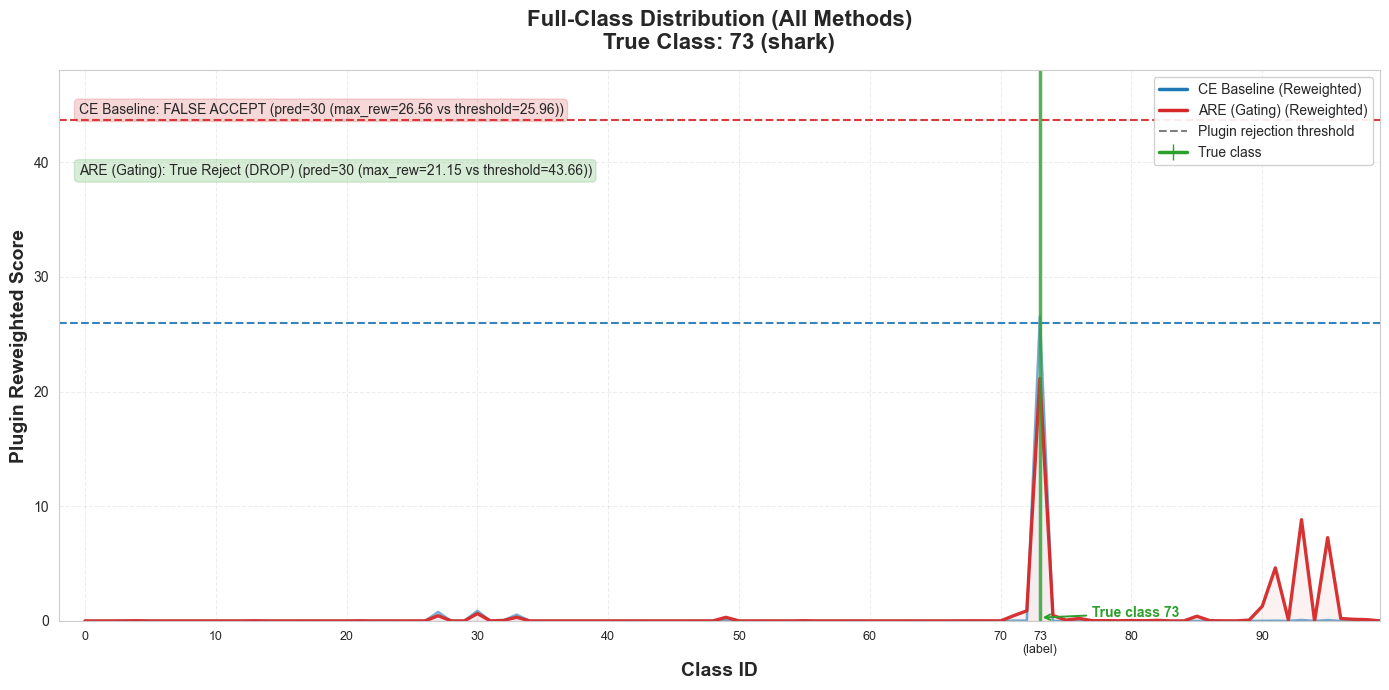

💡 Biểu đồ này hiển thị:
   - CE Baseline và Gating (ARE): Plugin Reweighted Score với plugin threshold
   - LogitAdjust và BalSoftmax: Posterior Probability với max-prob threshold
   💡 CE và Gating sử dụng plugin rejection rule: max_reweighted < threshold


In [9]:
# Plot full-class distribution for all methods (CE, LA, BS, Gating)
# CE and Gating: Plugin Reweighted Score with plugin threshold
# LogitAdjust and BalSoftmax: Posterior Probability with max-prob threshold

fig_all = plot_full_class_distribution(
    true_label=true_label,
    paper_result=paper_result,
    our_result=our_result,
    class_names=class_names,
    title=f"Full-Class Distribution (All Methods)\nTrue Class: {true_label} ({class_names[true_label]})",
    use_plugin_threshold=True,  # Use plugin rejection rule (max_reweighted < threshold) for CE and Gating
    plot_reweighted_scores=True  # Plot Plugin Reweighted Score for CE and Gating, probabilities for LA and BS
)
plt.show()

print("💡 Biểu đồ này hiển thị:")
print("   - CE Baseline và Gating (ARE): Plugin Reweighted Score với plugin threshold")
print("   - LogitAdjust và BalSoftmax: Posterior Probability với max-prob threshold")
print("   💡 CE và Gating sử dụng plugin rejection rule: max_reweighted < threshold")


### 7.5 Plugin Reject Rule Terms

So sánh trực tiếp hai vế của công thức reject: `max_reweighted` (vế trái) và `threshold = Σ(1/α̂ - μ)·η(x) - cost` (vế phải).


In [10]:
def compute_plugin_terms(posterior, plugin_params, class_to_group_tensor):
    alpha = np.array(plugin_params['alpha'])
    mu = np.array(plugin_params['mu'])
    cost = float(plugin_params['cost'])
    plugin = BalancedLtRPlugin(class_to_group_tensor, alpha, mu, cost)
    posterior_tensor = torch.tensor(posterior, dtype=torch.float32, device=class_to_group_tensor.device).unsqueeze(0)
    eps = 1e-12
    alpha_hat = plugin._alpha_hat_class().clamp(min=eps)
    mu_tensor = plugin._mu_class()
    inv_alpha_hat = 1.0 / alpha_hat
    lhs = (posterior_tensor * inv_alpha_hat.unsqueeze(0)).max(dim=-1)[0].item()
    rhs = ((inv_alpha_hat - mu_tensor).unsqueeze(0) * posterior_tensor).sum(dim=-1).item() - plugin.cost
    return lhs, rhs

paper_lhs, paper_rhs = compute_plugin_terms(
    paper_result['probabilities'],
    paper_result['plugin_params'],
    class_to_group,
)
our_lhs, our_rhs = compute_plugin_terms(
    our_result['mixture_posterior'],
    our_result['plugin_params'],
    class_to_group,
)

print("📊 Plugin reject rule terms (max_reweighted vs threshold):")
print(f"   Paper Method: max_reweighted = {paper_lhs:.4f}, threshold = {paper_rhs:.4f}")
print(f"   Our Method:   max_reweighted = {our_lhs:.4f}, threshold = {our_rhs:.4f}")
print("\n   💡 Rule: Reject nếu max_reweighted < threshold (per-sample).")

📊 Plugin reject rule terms (max_reweighted vs threshold):
   Paper Method: max_reweighted = 26.5603, threshold = 25.9551
   Our Method:   max_reweighted = 21.1469, threshold = 43.6641

   💡 Rule: Reject nếu max_reweighted < threshold (per-sample).


### 7.6 Rejection Decision

### Expert Posterior Distributions


/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_79866/2001771747.py:78: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_79866/2001771747.py:78: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


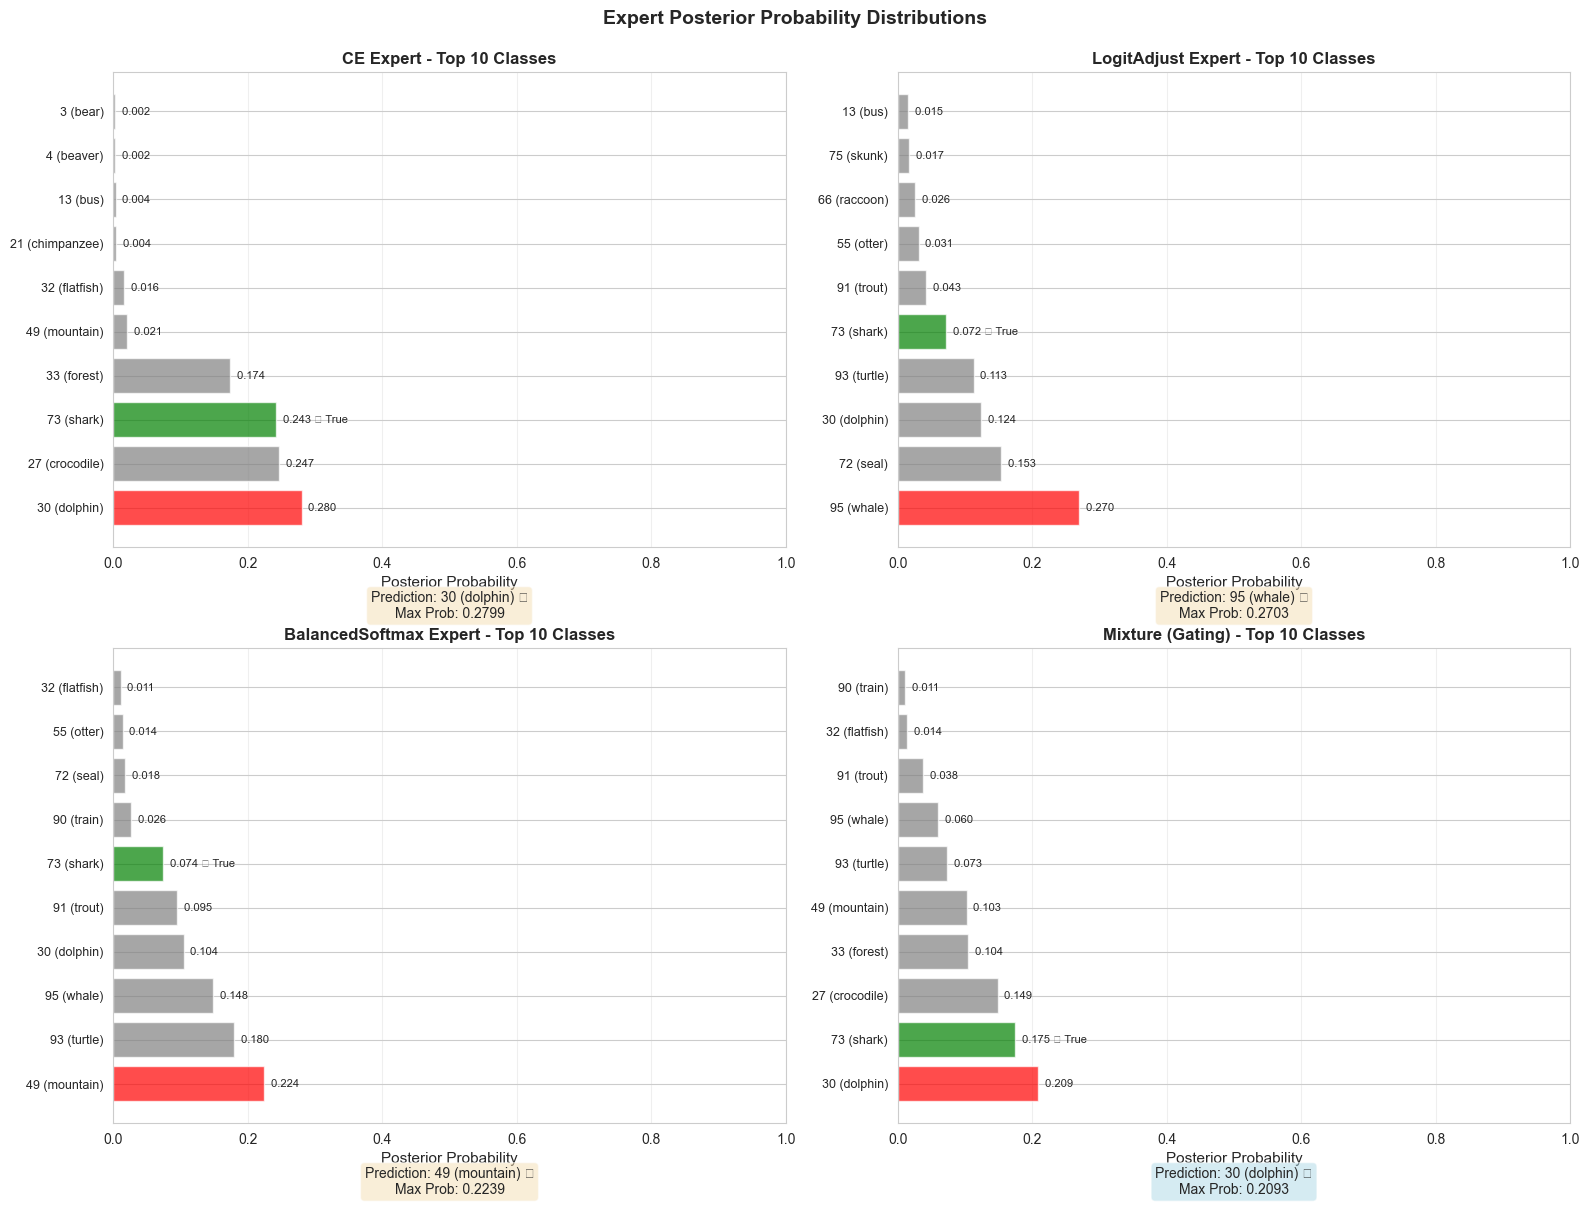


📊 Expert Posterior Statistics

CE:
  Max probability: 0.2799 (class 30: dolphin)
  True class probability: 0.2427 (class 73: shark)
  Entropy: 1.6238
  Variance: 0.002190

LogitAdjust:
  Max probability: 0.2703 (class 95: whale)
  True class probability: 0.0716 (class 73: shark)
  Entropy: 2.5291
  Variance: 0.001247

BalancedSoftmax:
  Max probability: 0.2239 (class 49: mountain)
  True class probability: 0.0745 (class 73: shark)
  Entropy: 2.4429
  Variance: 0.001219

Mixture (Gating):
  Max probability: 0.2093 (class 30: dolphin)
  True class probability: 0.1749 (class 73: shark)
  Entropy: 2.3612
  Variance: 0.001189


In [11]:
# Plot posterior distributions for each expert
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get expert posteriors from our_result
expert_probs = our_result['expert_probs']  # List of 3 arrays, each [100]
expert_names = EXPERT_DISPLAY_NAMES

# Top-10 classes for each expert
top_k = 10

for idx, (name, probs) in enumerate(zip(expert_names, expert_probs)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Get top-k classes
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    top_classes = [class_names[i] for i in top_indices]
    
    # Color by correctness
    colors = ['green' if i == true_label else 'red' if i == probs.argmax() else 'gray' 
              for i in top_indices]
    
    bars = ax.barh(range(top_k), top_probs, color=colors, alpha=0.7)
    ax.set_yticks(range(top_k))
    ax.set_yticklabels([f"{idx} ({name})" for idx, name in zip(top_indices, top_classes)], fontsize=9)
    ax.set_xlabel('Posterior Probability', fontsize=11)
    ax.set_title(f'{name} Expert - Top {top_k} Classes', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Annotate bars
    for i, (prob, class_idx) in enumerate(zip(top_probs, top_indices)):
        label = '✓ True' if class_idx == true_label else ''
        ax.text(prob + 0.01, i, f'{prob:.3f} {label}', va='center', fontsize=8)
    
    # Add prediction indicator
    pred_idx = probs.argmax()
    pred_prob = probs[pred_idx]
    is_correct = '✅' if pred_idx == true_label else '❌'
    ax.text(0.5, -0.15, f'Prediction: {pred_idx} ({class_names[pred_idx]}) {is_correct}\nMax Prob: {pred_prob:.4f}',
            transform=ax.transAxes, ha='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Mixture posterior (bottom right)
ax = axes[1, 1]
mixture_probs = our_result['mixture_posterior']
top_indices = np.argsort(mixture_probs)[-top_k:][::-1]
top_probs = mixture_probs[top_indices]
top_classes = [class_names[i] for i in top_indices]

colors = ['green' if i == true_label else 'red' if i == mixture_probs.argmax() else 'gray' 
          for i in top_indices]

bars = ax.barh(range(top_k), top_probs, color=colors, alpha=0.7)
ax.set_yticks(range(top_k))
ax.set_yticklabels([f"{idx} ({name})" for idx, name in zip(top_indices, top_classes)], fontsize=9)
ax.set_xlabel('Posterior Probability', fontsize=11)
ax.set_title(f'Mixture (Gating) - Top {top_k} Classes', fontsize=12, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')

# Annotate bars
for i, (prob, class_idx) in enumerate(zip(top_probs, top_indices)):
    label = '✓ True' if class_idx == true_label else ''
    ax.text(prob + 0.01, i, f'{prob:.3f} {label}', va='center', fontsize=8)

# Add prediction indicator
pred_idx = mixture_probs.argmax()
pred_prob = mixture_probs[pred_idx]
is_correct = '✅' if pred_idx == true_label else '❌'
ax.text(0.5, -0.15, f'Prediction: {pred_idx} ({class_names[pred_idx]}) {is_correct}\nMax Prob: {pred_prob:.4f}',
        transform=ax.transAxes, ha='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.suptitle('Expert Posterior Probability Distributions', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("📊 Expert Posterior Statistics")
print("="*70)
for name, probs in zip(expert_names, expert_probs):
    print(f"\n{name}:")
    print(f"  Max probability: {probs.max():.4f} (class {probs.argmax()}: {class_names[probs.argmax()]})")
    print(f"  True class probability: {probs[true_label]:.4f} (class {true_label}: {class_names[true_label]})")
    print(f"  Entropy: {-np.sum(probs * np.log(probs + 1e-10)):.4f}")
    print(f"  Variance: {probs.var():.6f}")

print(f"\nMixture (Gating):")
print(f"  Max probability: {mixture_probs.max():.4f} (class {mixture_probs.argmax()}: {class_names[mixture_probs.argmax()]})")
print(f"  True class probability: {mixture_probs[true_label]:.4f} (class {true_label}: {class_names[true_label]})")
print(f"  Entropy: {-np.sum(mixture_probs * np.log(mixture_probs + 1e-10)):.4f}")
print(f"  Variance: {mixture_probs.var():.6f}")


In [12]:
# Rejection Decision Comparison với 4 trường hợp

def classify_rejection_decision(prediction, true_label, reject):
    """
    Phân loại rejection decision thành 4 trường hợp:
    - True Accept (TA): Accept và đúng → Tốt nhất!
    - False Accept (FA): Accept nhưng sai → Nguy hiểm!
    - False Reject (FR): Reject nhưng đúng → Lãng phí (nên accept)
    - True Reject (TR): Reject và sai → Đúng nên reject
    """
    is_correct = (prediction == true_label)
    
    if not reject:  # ACCEPT
        if is_correct:
            return "True Accept (TA)", "✅"
        else:
            return "False Accept (FA)", "❌"
    else:  # REJECT
        if is_correct:
            return "False Reject (FR)", "⚠️"
        else:
            return "True Reject (TR)", "✅"

# Paper Method
paper_pred = paper_result['prediction']
paper_reject = paper_result['reject']
paper_decision, paper_icon = classify_rejection_decision(paper_pred, true_label, paper_reject)

# Our Method
our_pred = our_result['prediction']
our_reject = our_result['reject']
our_decision, our_icon = classify_rejection_decision(our_pred, true_label, our_reject)

print("📊 Rejection Decision Analysis:")
print("="*70)
print(f"   True Label: {true_label} ({class_names[true_label]})")
print(f"📄 Paper Method (CE + Plugin):")
print(f"   Reject: {'YES' if paper_reject else 'NO'}")
print(f"   Decision: {paper_decision} {paper_icon}")

print(f"🚀 Our Method (MoE + Gating + Plugin):")
print(f"   Reject: {'YES' if our_reject else 'NO'}")
print(f"   Decision: {our_decision} {our_icon}")


📊 Rejection Decision Analysis:
   True Label: 73 (shark)
📄 Paper Method (CE + Plugin):
   Reject: NO
   Decision: False Accept (FA) ❌
🚀 Our Method (MoE + Gating + Plugin):
   Reject: YES
   Decision: True Reject (TR) ✅


📊 Expert Contributions:
   CE:
      Prediction: 30 (dolphin) ❌
      Gating Weight: 0.5973
      Max Probability: 0.2799
   LogitAdjust:
      Prediction: 95 (whale) ❌
      Gating Weight: 0.0000
      Max Probability: 0.2703
   BalancedSoftmax:
      Prediction: 49 (mountain) ❌
      Gating Weight: 0.4027
      Max Probability: 0.2239


/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_79866/385168248.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()


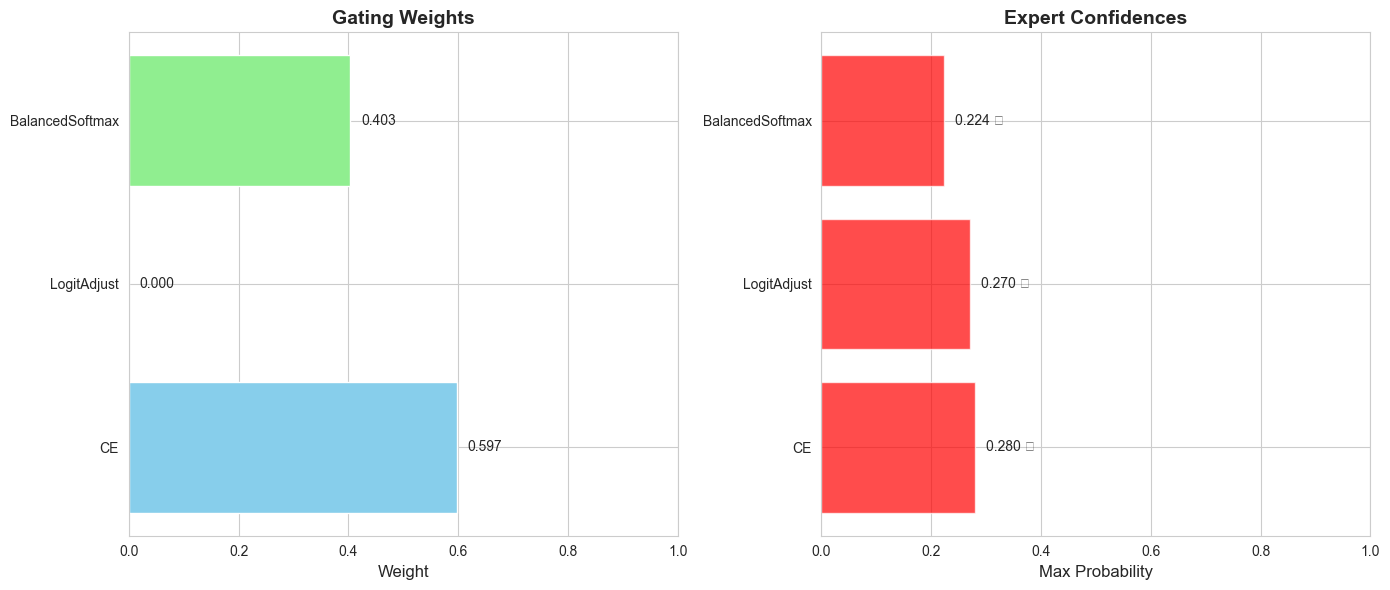

In [13]:
# Expert Contributions
expert_names = EXPERT_DISPLAY_NAMES
expert_preds = our_result['expert_predictions']
gating_weights = our_result['gating_weights']
expert_probs = our_result['expert_probs']

print("📊 Expert Contributions:")
for i, (name, pred, weight, probs) in enumerate(zip(expert_names, expert_preds, gating_weights, expert_probs)):
    correct = '✅' if pred == true_label else '❌'
    max_prob = np.max(probs)
    print(f"   {name}:")
    print(f"      Prediction: {pred} ({class_names[pred]}) {correct}")
    print(f"      Gating Weight: {weight:.4f}")
    print(f"      Max Probability: {max_prob:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gating weights
ax1 = axes[0]
ax1.barh(expert_names, gating_weights, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Gating Weights', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
for i, (name, weight) in enumerate(zip(expert_names, gating_weights)):
    ax1.text(weight + 0.02, i, f'{weight:.3f}', va='center', fontsize=10)

# Expert confidences
ax2 = axes[1]
expert_confidences = [np.max(probs) for probs in expert_probs]
colors = ['green' if pred == true_label else 'red' for pred in expert_preds]
ax2.barh(expert_names, expert_confidences, color=colors, alpha=0.7)
ax2.set_xlabel('Max Probability', fontsize=12)
ax2.set_title('Expert Confidences', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
for i, (name, conf, pred) in enumerate(zip(expert_names, expert_confidences, expert_preds)):
    status = '✅' if pred == true_label else '❌'
    ax2.text(conf + 0.02, i, f'{conf:.3f} {status}', va='center', fontsize=10)

plt.tight_layout()
plt.show()